
#use multinomial naive bayes algorithm after the other models

# Imports

In [94]:
from pprint import pprint
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import spacy
import re
import wrangle, model

from importlib import reload
from itertools import product
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint


In [95]:
reload(wrangle)

<module 'wrangle' from '/Users/sinao/codeup-data-science/nlp_project/wrangle.py'>

In [96]:
df = wrangle.get_search_csv()
df = wrangle.prep_text(df)


Removed 201 stopwords
---

Removed 49 stopwords
---

Removed 2 stopwords
---

Removed 218 stopwords
---

Removed 401 stopwords
---

Removed 0 stopwords
---

Removed 50 stopwords
---

Removed 8 stopwords
---

Removed 158 stopwords
---

Removed 21 stopwords
---

Removed 44 stopwords
---

Removed 110 stopwords
---

Removed 500 stopwords
---

Removed 494 stopwords
---

Removed 31 stopwords
---

Removed 427 stopwords
---

Removed 76 stopwords
---

Removed 1 stopwords
---

Removed 175 stopwords
---

Removed 731 stopwords
---

Removed 68 stopwords
---

Removed 58 stopwords
---

Removed 358 stopwords
---

Removed 52 stopwords
---

Removed 15 stopwords
---

Removed 48 stopwords
---

Removed 100 stopwords
---

Removed 116 stopwords
---

Removed 0 stopwords
---

Removed 134 stopwords
---

Removed 320 stopwords
---

Removed 27 stopwords
---

Removed 74 stopwords
---

Removed 88 stopwords
---

Removed 8 stopwords
---

Removed 272 stopwords
---

Removed 123 stopwords
---

Removed 389 stopwords
---


In [97]:
df = df[['language', 'lemmatized']]

In [98]:
df.lemmatized

0      p aligncenter img srchttpsuserimagesgithubuser...
1      platform12 github license34 github license56 1...
2      dunk httpsrawgithubusercontentcomnaoyashigadun...
3      p aligncenter img srcstaticimganalysisgif widt...
5      nba nodejs client nbacom api endpoint npm inst...
                             ...                        
102    basketballrecleague purpose project demonstrat...
103    nbastartactiveplayersbot python selenium scrip...
106    shoot teamshttpsshootforteamscom app designed ...
107    pandasbasketball pandasbasketball small module...
108    basketball game demo base opengl grapic render...
Name: lemmatized, Length: 98, dtype: object

# Modeling

## Fit Vectorizer

# Setup
Explore various models and feature combinations.
Choose **three** models to validate. Choose **one** to test. 
Artifact: `model.py`

### Modeling Preparation
- Create function to vectorize, scale, and split data
- Create word_count feature --> backport to wrangle

### Baseline Prediction and Accuracy

In [99]:
for i in df.index:
    df.loc[i, 'word_count'] = len([word for word in df.loc[i, 'lemmatized'].split()])

In [100]:
df.word_count

0      483.0
1      478.0
2        5.0
3      427.0
5      571.0
       ...  
102     78.0
103    178.0
106    140.0
107    474.0
108     51.0
Name: word_count, Length: 98, dtype: float64

In [101]:

def vectorize_split(df):

    """ 
    Purpose:
        
    ---
    Parameters:
        
    ---
    Returns:
        X_train, y_train, X_validate, y_validate, X_test, y_test: data subsets
    """

    tfidf = TfidfVectorizer()
    df['lemmatized'] = tfidf.fit_transform(df.lemmatized).todense()

    scaler = preprocessing.MinMaxScaler()
    scaler.fit_transform(df[['word_count']])

    train_validate, test = train_test_split(df, test_size=.3, random_state=514, stratify=df['language'])
    train, validate = train_test_split(train_validate, test_size=.3, random_state=514, stratify=train_validate['language'])

    # split data into Big X, small y sets 
    X_train = train.drop(columns=['language'])
    y_train = train.language

    X_validate = validate.drop(columns=['language'])
    y_validate = validate.language

    X_test = test.drop(columns=['language'])
    y_test = test.language

    return train, X_train, y_train, X_validate, y_validate, X_test, y_test

In [102]:
train, X_train, y_train, X_validate, y_validate, X_test, y_test = vectorize_split(df)

In [103]:
# formulate baseline prediction ->base prediction is python
train.language.value_counts(normalize=True)

Python              0.297872
Other               0.255319
Jupyter Notebook    0.127660
JavaScript          0.127660
R                   0.127660
HTML                0.063830
Name: language, dtype: float64

In [104]:
def compute_metrics(model, X_df, y_df):
    """
    purpose: function executes performs computations to produce evaulation metrics for a given model

    inputs: 
        model: a model that has been previous fit to spec
        X_df: a dataframe featuring the X subset of data for evaluation
        y_df: a dataframe featuring the model target variable

    Returns: a rounded pandas Series that can be adding to an evaulation metric comparison chart
    """
    # Make Predictions
    y_pred = model.predict(X_df)

    # Estimate Probability 
    y_pred_proba = model.predict_proba(X_df)

    #create confusion matrix
    confusion = confusion_matrix(y_df, y_pred)

    #assign results of confusion matrix to variables
    true_negative = confusion[0,0]
    false_positive = confusion[0,1]
    false_negative = confusion[1,0]
    true_positive = confusion[1,1]

    #accuracy
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    #true positive rate / recall
    recall = true_positive / (true_positive +false_negative)

    #false positive rate
    false_positive_rate = false_positive / (true_negative + false_positive)

    #true negative rate
    true_negative_rate = true_negative / (true_negative + false_positive)

    #false negative rate
    false_negative_rate = false_negative / (false_negative + true_positive)

    #precision
    precision = true_positive / (true_positive + false_positive)

    #f1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    #support
    support_positive = true_positive + false_negative
    support_negative = false_positive + true_negative

    metrics = pd.Series([accuracy, true_positive, false_positive, true_negative, false_negative,\
                        recall, false_positive_rate, true_negative_rate, false_negative_rate, \
                        precision, f1_score, support_positive, support_negative])
                        
    return metrics.round(4)

In [105]:
def create_comp_chart():
    """
    purpose: to create a dataframe with an index reflecting compuation metrics for future models

    returns: a pandas dataframe with appropriately set index
    """
    statistics = ['Accuracy/Score',
    'True Positives' , 'False Positives', 'True Negatives', 'False Negatives', \
    'TPR/Recall', 'False Positive Rate', 'True Negative Rate', 'False Negative Rate', \
    'Precision', 'F1-Score', 'Support Positive', 'Support Negative']


    return pd.DataFrame({}, index=statistics)

In [106]:
# formulate baseline accuracy
baseline_accuracy = (y_train == 'Python').mean()

print(f'Baseline Accuracy for \"language\" prediction: {(baseline_accuracy * 100): .3}%')

Baseline Accuracy for "language" prediction:  29.8%


In [107]:
def create_description_chart(y):

    # formulate baseline accuracy
    baseline_accuracy = (y == 'Python').mean()

    descriptions = pd.DataFrame({'Model': 'Baseline', \
                                'Accuracy(Score)': baseline_accuracy,
                                'Type': 'Basic Baseline',
                                'Features Used': 'Baseline Prediction',
                                'Parameters': 'n/a'
                                }, index=[0])
    
    return descriptions

In [108]:
model_descriptions = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0])

In [109]:
pd.concat([model_descriptions, pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0]) ], ignore_index=True)

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.297872,Basic Baseline,Baseline Prediction,n/a
1,Baseline,0.297872,Basic Baseline,Baseline Prediction,n/a


In [110]:
comparison_chart = model.create_comp_chart()

# Models

## Decision Tree

In [111]:
feat_set = ['word_count', 'lemmatized']

In [112]:
subsets = [train, X_train, y_train, X_validate, y_validate]

In [113]:
def model_dtc(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product(np.arange(20,25,2)))

    for idx, item in enumerate(selectors):
        model_id = 'DTC_'+f'{idx}'
        dtc = DecisionTreeClassifier(max_depth=item[0],\
                                            random_state=514)
        
        dtc.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(dtc, X_train[features], y_train).values

        score = dtc.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Decision Tree Classifier',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}'},
                                    index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [114]:
model_descriptions, comparison_chart =  model_dtc(feat_set, model_descriptions, comparison_chart, subsets)

In [115]:
model_descriptions

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.297872,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.957400,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 20
2,DTC_1,0.957400,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 22
3,DTC_2,0.957400,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 24


## Random Forest

In [116]:
def model_rf(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product([20,25], [3,2,1]))

    for idx, item in enumerate(selectors):
        model_id = 'RF_'+f'{idx}'
        rf = RandomForestClassifier(max_depth=item[0],\
                                            min_samples_leaf=item[1],
                                            random_state=514)
        
        rf.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(rf, X_train[features], y_train).values

        score = rf.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Random Forest',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}, Leaves: {item[1]}'},
                                    index=[0])
       
    model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [117]:
model_descriptions, comparison_chart = model_rf(feat_set, model_descriptions, comparison_chart, subsets)

### Takeaways - Random Forest
* 

## KNN (K-Nearest Neighbors)

In [118]:
## K-Nearest Neighbors
def model_knn(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    k_range = range(1, 15)
    scores = []
    
    for k in k_range:
        
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train[features], y_train)
        scores.append(knn.score(X_train[features], y_train))

        model_id = 'Knn_'+f'{k}'

        comparison_chart[model_id] = model.compute_metrics(knn, X_train[features], y_train).values

        score = knn.score(X_train[features], y_train).round(5)

        description = pd.DataFrame({'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Knn',
            'Features Used': f'{feat_set}',
            'Parameters': f'K-Neighbors: {k}'},
            index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)
   
    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.scatter(k_range, scores)
    plt.xticks([0,5,10,15,20])
    plt.show()
    np.mean(scores)

    
    return model_descriptions, comparison_chart

/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy
/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy
/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy


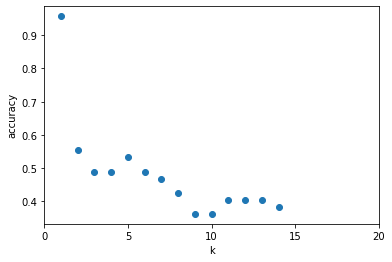

In [119]:
model_descriptions, comparison_chart = model_knn(feat_set, model_descriptions, comparison_chart, subsets)

In [120]:
model_descriptions.sort_values(by='Accuracy(Score)', ascending=False).head()

,Model,Accuracy(Score),Type,Features Used,Parameters
5,Knn_1,0.95745,Knn,"['word_count', 'lemmatized']",K-Neighbors: 1
2,DTC_1,0.95740,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 22
3,DTC_2,0.95740,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 24
4,RF_5,0.95740,Random Forest,"['word_count', 'lemmatized']","Depth: 25, Leaves: 1"
1,DTC_0,0.95740,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 20


## Logistic Regression

In [121]:
def model_lr(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    cees = [.1,.5,1]
    solver = ['newton-cg', 'lbfgs']
    weights = [None, 'balanced']

    selectors = list(product(cees, solver, weights))

    for idx, item in enumerate(selectors):
        model_id = 'LR_'+f'{idx}'
        lr = LogisticRegression(C=item[0],\
                                solver=item[1],
                                class_weight=item[2],
                                max_iter=400,
                                random_state=514)
        
        lr.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(lr, X_train[features], y_train).values

        score = lr.score(X_train[features], y_train).round(4)

        model_descriptions.loc[idx+1] = {'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Logistic Regression',
            'Features Used': f'{feat_set}',
            'Parameters': f'C: {item[0]}, Solver: {item[1]}, Class Weight: {item[2]}'
        }

    return model_descriptions, comparison_chart

In [122]:
reload(model)

<module 'model' from '/Users/sinao/codeup-data-science/nlp_project/model.py'>

In [123]:
model_descriptions, comparison_chart = model_lr(feat_set, model_descriptions, comparison_chart, subsets)

## Model Description and Comparison Charts


In [124]:
model_descriptions.groupby('Type')['Accuracy(Score)'].mean()

Type
Basic Baseline         0.297872
Knn                    0.386527
Logistic Regression    0.329800
Name: Accuracy(Score), dtype: float64

In [125]:
#model descriptions
model_descriptions.sort_values('Accuracy(Score)', ascending=False).head(5)

,Model,Accuracy(Score),Type,Features Used,Parameters
9,LR_8,0.4043,Logistic Regression,"['word_count', 'lemmatized']","C: 1, Solver: newton-cg, Class Weight: None"
1,LR_0,0.4043,Logistic Regression,"['word_count', 'lemmatized']","C: 0.1, Solver: newton-cg, Class Weight: None"
3,LR_2,0.4043,Logistic Regression,"['word_count', 'lemmatized']","C: 0.1, Solver: lbfgs, Class Weight: None"
5,LR_4,0.4043,Logistic Regression,"['word_count', 'lemmatized']","C: 0.5, Solver: newton-cg, Class Weight: None"
7,LR_6,0.4043,Logistic Regression,"['word_count', 'lemmatized']","C: 0.5, Solver: lbfgs, Class Weight: None"


In [126]:
comparison_chart.T.sort_values(by='True Negatives', ascending=False).head(25).sort_values(by=['Accuracy/Score'])

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
LR_9,0.5000,1.0,1.0,1.0,1.0,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,2.0,2.0
Knn_10,0.5000,0.0,0.0,1.0,1.0,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0,1.0
LR_11,0.5000,1.0,1.0,1.0,1.0,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,2.0,2.0
LR_7,0.5000,1.0,1.0,1.0,1.0,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,2.0,2.0
LR_5,0.5000,1.0,1.0,1.0,1.0,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,2.0,2.0
LR_3,0.5000,1.0,1.0,1.0,1.0,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,2.0,2.0
LR_1,0.5000,1.0,1.0,1.0,1.0,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,2.0,2.0
Knn_9,0.6000,2.0,1.0,1.0,1.0,0.6667,0.5000,0.5000,0.3333,0.6667,0.6667,3.0,2.0
Knn_8,0.6667,3.0,1.0,1.0,1.0,0.7500,0.5000,0.5000,0.2500,0.7500,0.7500,4.0,2.0
Knn_7,0.7143,4.0,1.0,1.0,1.0,0.8000,0.5000,0.5000,0.2000,0.8000,0.8000,5.0,2.0


In [127]:
comparison_chart.T.sort_values(by='Accuracy/Score', ascending=False).head(25).sort_values(by=['False Positives'])

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
DTC_0,1.0000,6.0,0.0,3.0,0.0,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,6.0,3.0
Knn_2,0.7778,4.0,0.0,3.0,2.0,0.6667,0.0000,1.0000,0.3333,1.0000,0.8000,6.0,3.0
DTC_2,1.0000,6.0,0.0,3.0,0.0,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,6.0,3.0
RF_2,1.0000,6.0,0.0,3.0,0.0,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,6.0,3.0
RF_5,1.0000,6.0,0.0,3.0,0.0,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,6.0,3.0
LR_4,1.0000,1.0,0.0,0.0,0.0,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0,0.0
LR_2,1.0000,1.0,0.0,0.0,0.0,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0,0.0
Knn_3,0.8750,5.0,0.0,2.0,1.0,0.8333,0.0000,1.0000,0.1667,1.0000,0.9091,6.0,2.0
LR_10,1.0000,1.0,0.0,0.0,0.0,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0,0.0
LR_8,1.0000,1.0,0.0,0.0,0.0,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0,0.0


In [128]:
model_descriptions

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.297872,Basic Baseline,Baseline Prediction,n/a
1,LR_0,0.404300,Logistic Regression,"['word_count', 'lemmatized']","C: 0.1, Solver: newton-cg, Class Weight: None"
2,LR_1,0.255300,Logistic Regression,"['word_count', 'lemmatized']","C: 0.1, Solver: newton-cg, Class Weight: balanced"
3,LR_2,0.404300,Logistic Regression,"['word_count', 'lemmatized']","C: 0.1, Solver: lbfgs, Class Weight: None"
4,LR_3,0.255300,Logistic Regression,"['word_count', 'lemmatized']","C: 0.1, Solver: lbfgs, Class Weight: balanced"
5,LR_4,0.404300,Logistic Regression,"['word_count', 'lemmatized']","C: 0.5, Solver: newton-cg, Class Weight: None"
6,LR_5,0.255300,Logistic Regression,"['word_count', 'lemmatized']","C: 0.5, Solver: newton-cg, Class Weight: balanced"
7,LR_6,0.404300,Logistic Regression,"['word_count', 'lemmatized']","C: 0.5, Solver: lbfgs, Class Weight: None"
8,LR_7,0.255300,Logistic Regression,"['word_count', 'lemmatized']","C: 0.5, Solver: lbfgs, Class Weight: balanced"
9,LR_8,0.404300,Logistic Regression,"['word_count', 'lemmatized']","C: 1, Solver: newton-cg, Class Weight: None"


## Model Creation Takeaways
- 

## Model Validation Takeaways
- Goal:
    - 

In [129]:
top_20 = model_descriptions.sort_values('Accuracy(Score)', ascending=False).head(20)

In [130]:
def get_selectors(parameters):
    removal_list = ['Depth: ','K-Neighbors: ','Leaves: ','C: ',' Solver: ', ' Class Weight: ']

    for word in removal_list:
        parameters = parameters.replace(word, "")

    return parameters.split(',')

In [137]:
def score_on_validation(descriptions, subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_validate= subsets[3]
    y_validate = subsets[4]

    
    validate_metrics = create_comp_chart()
    val_descriptions = create_description_chart(y_validate)
    
    print(descriptions.index)
    for idx in descriptions.index:
        i = 1
        model_id = descriptions.loc[idx]['Model']
        feat_set = descriptions.loc[idx]['Features Used'].strip('\[]\'').split('\', \'')
        selectors = get_selectors(descriptions.loc[idx]['Parameters'])

        features = []

        for feature in feat_set:
            features += [col for col in train.columns if feature in col]

        if model_id.startswith('DTC'):
            val_model = DecisionTreeClassifier(max_depth=int(selectors[0]),\
                                                random_state=514)
        elif model_id.startswith('RF'):
            val_model = RandomForestClassifier(max_depth=int(selectors[0]),\
                                            min_samples_leaf=int(selectors[1]),
                                            random_state=514)
        elif model_id.startswith('Knn'):
            val_model = KNeighborsClassifier(n_neighbors = int(selectors[0]))
        elif model_id.startswith('LR'):
            if selectors[2]== 'None':
                selectors[2] = None
            val_model = LogisticRegression(C=float(selectors[0]),\
                                            solver=selectors[1],
                                            class_weight=selectors[2],
                                            max_iter=200,
                                            random_state=514)  

        #print(X_train[features], y_train)  
        try:                       
            val_model.fit(X_train[features], y_train)
        except:
            problem = X_train[features]
            problem_y = y_train
            # return problem, problem_y
        
        validate_metrics[model_id] = model.compute_metrics(val_model, X_validate[features], y_validate).values

        score = val_model.score(X_validate[features], y_validate).round(4)

        val_descriptions.loc[idx+1] = {'Model': model_id,
            'Accuracy(Score)': score,
            'Type': descriptions.loc[idx]['Type'],
            'Features Used': f'{feat_set}',
            'Parameters': descriptions.loc[idx]['Parameters']
        }
        
    val_descriptions.insert(loc=2, column='Sensitivity', value=0)

    for idx in val_descriptions.index:
        model_id = val_descriptions.loc[idx]['Model']
        if model_id != 'Baseline':
            val_descriptions.loc[idx, 'Sensitivity'] = validate_metrics.T.loc[model_id]['True Negative Rate']        


    return val_descriptions, validate_metrics

In [132]:
df[df.word_count == 0]

,language,lemmatized,word_count


In [138]:
reload(model)

<module 'model' from '/Users/sinao/codeup-data-science/nlp_project/model.py'>

In [139]:
val_descriptions, validate_metrics = score_on_validation(top_20, subsets)

Int64Index([9, 1, 3, 5, 7, 11, 17, 16, 15, 18, 13, 14, 0, 10, 8, 12, 6, 4, 2], dtype='int64')
    word_count  lemmatized
28         0.0       162.0
2          0.0         5.0
61         0.0        63.0
78         0.0        69.0
26         0.0       851.0
70         0.0       126.0
73         0.0         6.0
5          0.0       571.0
31         0.0       247.0
29         0.0        48.0
14         0.0       663.0
45         0.0       250.0
6          0.0        91.0
46         0.0       224.0
53         0.0       498.0
43         0.0       621.0
47         0.0        65.0
21         0.0       321.0
65         0.0       189.0
49         0.0         1.0
42         0.0       682.0
    word_count  lemmatized
28         0.0       162.0
2          0.0         5.0
61         0.0        63.0
78         0.0        69.0
26         0.0       851.0
70         0.0       126.0
73         0.0         6.0
5          0.0       571.0
31         0.0       247.0
29         0.0        48.0
14         0.0 

/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy
/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy
/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy
/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy
/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy
/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy
/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encountered in long_scalars
  #accuracy
/Users/sinao/codeup-data-science/nlp_project/model.py:260: RuntimeWarning: invalid value encounte

ValueError: at least one array or dtype is required

In [ ]:
val_descriptions

""
72
36
10
80
0
39
69
90
103
17


In [ ]:
type(validate_metrics)

pandas.core.series.Series

In [ ]:
validate_metrics.T.sort_values(by='True Negative Rate', ascending=False)

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
DTC_0,0.9665,11718.0,384.0,68.0,24.0,0.9980,0.8496,0.1504,0.0020,0.9683,0.9829,11742.0,452.0
DTC_1,0.9665,11718.0,384.0,68.0,24.0,0.9980,0.8496,0.1504,0.0020,0.9683,0.9829,11742.0,452.0
RF_5,0.9679,11737.0,386.0,66.0,5.0,0.9996,0.8540,0.1460,0.0004,0.9682,0.9836,11742.0,452.0
LR_2,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
LR_16,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
LR_0,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
LR_4,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
Knn_5,0.9671,11740.0,399.0,53.0,2.0,0.9998,0.8827,0.1173,0.0002,0.9671,0.9832,11742.0,452.0
Knn_8,0.9672,11742.0,400.0,52.0,0.0,1.0000,0.8850,0.1150,0.0000,0.9671,0.9833,11742.0,452.0
Knn_10,0.9671,11742.0,401.0,51.0,0.0,1.0000,0.8872,0.1128,0.0000,0.9670,0.9832,11742.0,452.0


### Takeaways
> Initial: All three chosen sets perform baseline. Need to re-adjust and re-attempt

In [ ]:
top_model = val_descriptions[val_descriptions.Model == 'DTC_0']

In [ ]:
top_model

,Model,Accuracy(Score),Type,Features Used,Parameters
1,DTC_0,0.9665,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20


In [ ]:
for idx in top_model.index:
    print(top_model.loc[idx]['Model'])

DTC_0


In [ ]:
def score_on_test(descriptions, subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_test = subsets[5]
    y_test = subsets[6]

    test_metrics = create_comp_chart()
    test_descriptions = create_description_chart(y_test)
        
    for idx in descriptions.index:
        
        model_id = descriptions.loc[idx]['Model']
        feat_set = descriptions.loc[idx]['Features Used'].strip('\[]\'').split('\', \'')
        selectors = get_selectors(descriptions.loc[idx]['Parameters'])

        features = []

        for feature in feat_set:
            features += [col for col in train.columns if feature in col]

        if model_id.startswith('DTC'):
            test_model = DecisionTreeClassifier(max_depth=int(selectors[0]),\
                                                random_state=514)
        elif model_id.startswith('RF'):
            test_model = RandomForestClassifier(max_depth=int(selectors[0]),\
                                            min_samples_leaf=int(selectors[1]),
                                            random_state=514)
        elif model_id.startswith('Knn'):
            test_model = KNeighborsClassifier(n_neighbors = int(selectors[0]))
        elif model_id.startswith('LR'):
            test_model = LogisticRegression(C=float(selectors[0]),\
                                            solver=selectors[1],
                                            class_weight=selectors[2],
                                            max_iter=200,
                                            random_state=514)  
                                    
        test_model.fit(X_train[features], y_train)

        test_metrics[model_id] = compute_metrics(test_model, X_test[features], y_test).values

        score = test_model.score(X_test[features], y_test).round(4)

        test_descriptions.loc[idx+1] = {'Model': model_id,
            'Accuracy(Score)': score,
            'Type': descriptions.loc[idx]['Type'],
            'Features Used': f'{feat_set}',
            'Parameters': descriptions.loc[idx]['Parameters']
        }

    return test_descriptions, test_metrics


In [ ]:
test_descriptions, test_metrics = score_on_test(top_model)

In [ ]:
test_metrics

,DTC_0
Accuracy/Score,0.9663
True Positives,9771.0000
False Positives,328.0000
True Negatives,49.0000
False Negatives,14.0000
TPR/Recall,0.9986
False Positive Rate,0.8700
True Negative Rate,0.1300
False Negative Rate,0.0014
Precision,0.9675


In [ ]:
def create_comp_chart():
    """
    purpose: to create a dataframe with an index reflecting compuation metrics for future models

    returns: a pandas dataframe with appropriately set index
    """
    statistics = ['Accuracy/Score',
    'True Positives' , 'False Positives', 'True Negatives', 'False Negatives', \
    'TPR/Recall', 'False Positive Rate', 'True Negative Rate', 'False Negative Rate', \
    'Precision', 'F1-Score', 'Support Positive', 'Support Negative']


    return pd.DataFrame({}, index=statistics)

In [ ]:
def train_models(X, y, feature_groups, subsets):
    
   #take in features sets and run them through each of the different types
   #of models and their variations
   train_descriptions = create_description_chart(y)
   train_metrics = create_comp_chart()

   for features in feature_groups:
      
      train_descriptions, train_metrics = model_dtc(features, train_descriptions, train_metrics, subsets)
      train_descriptions, train_metrics = model_rf(features, train_descriptions, train_metrics, subsets)
      #train_descriptions, train_metrics = model_knn(features, train_descriptions, train_metrics, subsets)
      train_descriptions, train_metrics = model_lr(features, train_descriptions, train_metrics, subsets)

   train_descriptions.insert(loc=2, column='Sensitivity', value=0)

   for idx in train_descriptions.index:
      model_id = train_descriptions.iloc[idx]['Model']
      if model_id != 'Baseline':
         train_descriptions.loc[idx, 'Sensitivity'] = train_metrics.T.loc[model_id]['True Negative Rate']
         
   return train_descriptions, train_metrics

In [ ]:
def for_final_report(train, feature_bank):

    X_train, y_train, X_validate, y_validate, X_test, y_test = split_X_y(train)

    subsets=[train, X_train, y_train, X_validate, y_validate, X_test, y_test]

    train_descriptions, train_metrics = train_models(X_train, y_train, feature_bank, subsets)

    train_descriptions[train_descriptions.Sensitivity > .20].\
        sort_values('Accuracy(Score)', ascending=False).\
        head(20)

    top_4 = train_descriptions[train_descriptions.Sensitivity > .20].\
        sort_values('Accuracy(Score)', ascending=False).\
        head(4)

    val_descriptions, validate_metrics = score_on_validation(top_4, subsets)

    top_1 = val_descriptions[(val_descriptions.Sensitivity > .20) & (val_descriptions['Accuracy(Score)'] > .66)].\
        sort_values('Sensitivity', ascending=False).\
        head(1)

    test_descriptions, test_metrics = score_on_test(top_1, subsets)

    return test_metrics

In [ ]:
for_final_report(train, [feat_set])

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Int64Index([12, 8, 10, 14], dtype='int64')


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,LR_7
Accuracy/Score,0.6684
True Positives,6554.0000
False Positives,139.0000
True Negatives,238.0000
False Negatives,3231.0000
TPR/Recall,0.6698
False Positive Rate,0.3687
True Negative Rate,0.6313
False Negative Rate,0.3302
Precision,0.9792
